# Dynamical and Topological Relationships

## Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json

import numpy as np
import pandas as pd
import scipy.stats as stats
import h5py
import matplotlib.pyplot as plt

os.chdir('../')
import Codebase

path_CoreData = '/Users/akhambhati/Remotes/hoth_research/CoreData/fMRI_multiband-mmattar/restdata'
path_PeriphData = '/Users/akhambhati/Remotes/hoth_research/PeriphData/ds-NMF_Subnetworks'
path_ModData = path_PeriphData + '/e02-DynFuncModule'
path_SubData = path_PeriphData + '/e03-DynFuncSubgraph'
path_ExpData = path_PeriphData + '/e04-CmpModuleSubgraph'

for path in [path_CoreData, path_PeriphData, path_ModData, path_SubData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

## Generate List of Data

In [2]:
subj_mod_ids = np.unique([full_subj_path.split('/')[-1].split('.')[0]
                          for full_subj_path in glob.iglob('{}/*.consensus_module.npz'.format(path_ModData))])
subj_sub_ids = np.unique([full_subj_path.split('/')[-1].split('.')[0]
                          for full_subj_path in glob.iglob('{}/*.consensus_subgraph.npz'.format(path_SubData))])
subj_cfg_ids = np.unique([full_subj_path.split('/')[-1].split('.')[0]
                          for full_subj_path in glob.iglob('{}/*.cfg_matr.npz'.format(path_SubData))])

if not len(np.intersect1d(subj_mod_ids, subj_sub_ids)) == len(subj_mod_ids):
    raise Exception('Subject files mismatched')
if not len(np.intersect1d(subj_mod_ids, subj_cfg_ids)) == len(subj_mod_ids):
    raise Exception('Subject files mismatched')
    
subj_dict = {}
for subj in subj_mod_ids:
    subj_dict[subj] = {'module_path': '{}/{}.consensus_module.npz'.format(path_ModData, subj),
                       'subgraph_path': '{}/{}.consensus_subgraph.npz'.format(path_SubData, subj),
                       'cfg_path': '{}/{}.cfg_matr.npz'.format(path_SubData, subj)}

## Inter/Intra Module Connectivity of Subgraphs

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s


/Users/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


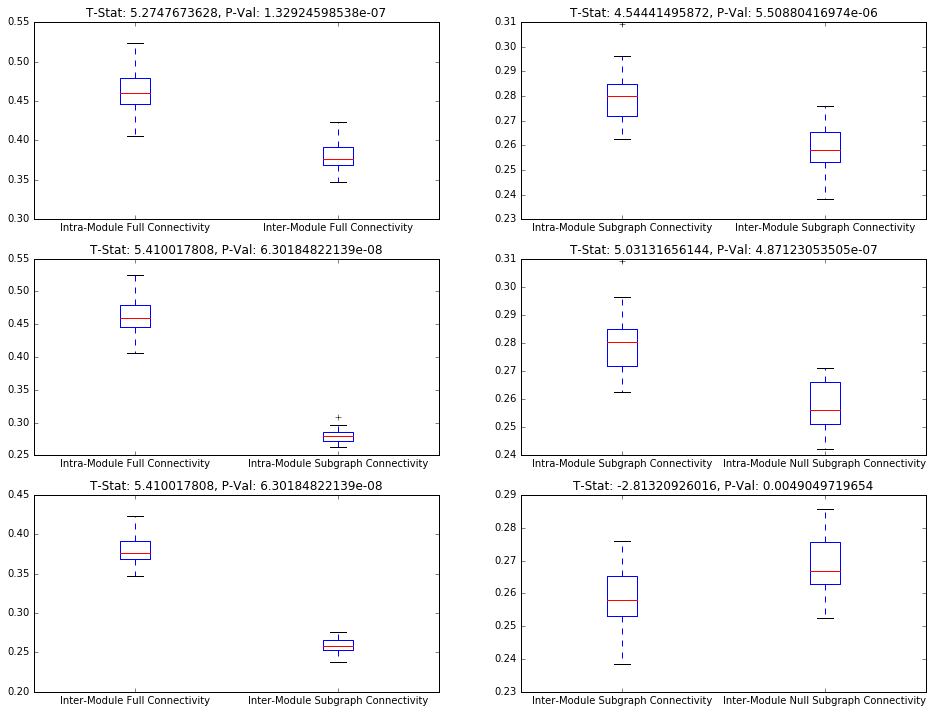

In [4]:
%matplotlib inline

n_null = 1

intra_module_subg_conn_pop = []
intra_module_subg_conn_pop_null = []
intra_module_full_conn_pop = []

inter_module_subg_conn_pop = []
inter_module_subg_conn_pop_null = []
inter_module_full_conn_pop = []

n_subj = len(subj_dict.keys())
for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    data_cfg = np.load(subj_dict[subj]['cfg_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
    cfg_matr = data_cfg['cfg_matr']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    # Real Intra/Inter Module Full Connectivity
    intra_module_subj = []
    inter_module_subj = []
    for iw in xrange(n_win):
        full_adj = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(cfg_matr[iw, :] / \
                                                                                np.max(cfg_matr[iw, :]))
        module_id = np.unique(module_assign[iw, :])

        for m_id in module_id:
            in_nodes = np.flatnonzero(module_assign[iw, :] == m_id)
            out_nodes = np.setdiff1d(np.arange(n_node), in_nodes)

            in_1, in_2 = np.meshgrid(in_nodes, in_nodes)
            intra_module_subj.append(np.nanmean(full_adj[in_1, in_2]))

            in_1, out_2 = np.meshgrid(in_nodes, out_nodes)
            inter_module_subj.append(np.nanmean(full_adj[in_1, out_2]))
    intra_module_full_conn_pop.append(np.nanmean(intra_module_subj))
    inter_module_full_conn_pop.append(np.nanmean(inter_module_subj))

    
    # Real Intra/Inter Module Subgraph Connectivity
    intra_module_subj = []
    inter_module_subj = []
    for ii in xrange(n_fac):
        subgraph_adj = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(fac_subgraph[ii, :] / \
                                                                                    np.max(fac_subgraph[ii, :]))

        for iw in xrange(n_win):
            module_id = np.unique(module_assign[iw, :])
            
            for m_id in module_id:
                in_nodes = np.flatnonzero(module_assign[iw, :] == m_id)
                out_nodes = np.setdiff1d(np.arange(n_node), in_nodes)

                in_1, in_2 = np.meshgrid(in_nodes, in_nodes)
                intra_module_subj.append(np.nanmean(subgraph_adj[in_1, in_2]))
                
                in_1, out_2 = np.meshgrid(in_nodes, out_nodes)
                inter_module_subj.append(np.nanmean(subgraph_adj[in_1, out_2]))
    intra_module_subg_conn_pop.append(np.nanmean(intra_module_subj))
    inter_module_subg_conn_pop.append(np.nanmean(inter_module_subj))
    
    # Null Intra/Inter Module Connectivity
    intra_module_subj = []
    inter_module_subj = []
    for ii in xrange(n_fac):
        null_fac_subgraph = np.random.permutation(fac_subgraph[ii, :])
        subgraph_adj = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(null_fac_subgraph / \
                                                                                    np.max(null_fac_subgraph))
        for iw in xrange(n_win):
            module_id = np.unique(module_assign[iw, :])

            for m_id in module_id:
                in_nodes = np.flatnonzero(module_assign[iw, :] == m_id)
                out_nodes = np.setdiff1d(np.arange(n_node), in_nodes)

                in_1, in_2 = np.meshgrid(in_nodes, in_nodes)
                intra_module_subj.append(np.nanmean(subgraph_adj[in_1, in_2]))

                in_1, out_2 = np.meshgrid(in_nodes, out_nodes)
                inter_module_subj.append(np.nanmean(subgraph_adj[in_1, out_2]))
    intra_module_subg_conn_pop_null.append(np.nanmean(intra_module_subj))
    inter_module_subg_conn_pop_null.append(np.nanmean(inter_module_subj))
    
    


cases_list = [('Intra-Module Full Connectivity', intra_module_full_conn_pop),
              ('Intra-Module Subgraph Connectivity', intra_module_subg_conn_pop),
              ('Intra-Module Null Subgraph Connectivity', intra_module_subg_conn_pop_null),
              ('Inter-Module Full Connectivity', inter_module_full_conn_pop),
              ('Inter-Module Subgraph Connectivity', inter_module_subg_conn_pop),
              ('Inter-Module Null Subgraph Connectivity', inter_module_subg_conn_pop_null)]

pairs = [[cases_list[0], cases_list[3]],
         [cases_list[1], cases_list[4]],
         [cases_list[0], cases_list[1]],
         [cases_list[1], cases_list[2]],
         [cases_list[3], cases_list[4]],         
         [cases_list[4], cases_list[5]]]

plt.figure(figsize=(16, 12))
for p_i, pair in enumerate(pairs):
    t, p = stats.ranksums(pair[0][1], pair[1][1])
    ax = plt.subplot(3, 2, p_i+1)
    ax.boxplot([pair[0][1], pair[1][1]])
    ax.set_xticklabels([pair[0][0], pair[1][0]])
    ax.set_title('T-Stat: {}, P-Val: {}'.format(t, p))   

## Which Subgraphs Capture Network Modules?

 -- Processing: h010615p


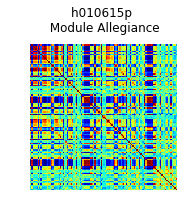

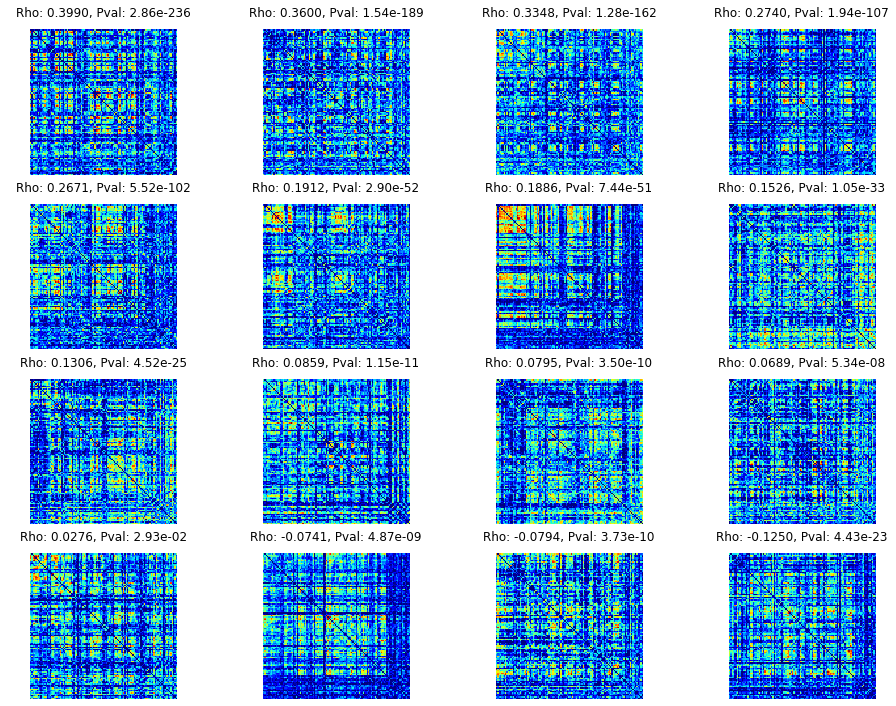

 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o
RanksumsResult(statistic=7.7419032595748289, pvalue=9.7939500150038036e-15)
RanksumsResult(statistic=7.7419032595748289, pvalue=9.7939500150038036e-15)
RanksumsResult(statistic=7.7419032595748289, pvalue=9.7939500150038036e-15)
RanksumsResult(statistic=7.7419032595748289, pvalue=9.7939500150038036e-15)
RanksumsResult(statistic=7.7419032595748289, pvalue=9.7939500150038036e-15)
RanksumsResult(statistic=7.7419032595748289, pvalue=9.7939500150038036e-15)
RanksumsResult(statistic=7.7419032595748289, pvalue=9.793950015003803

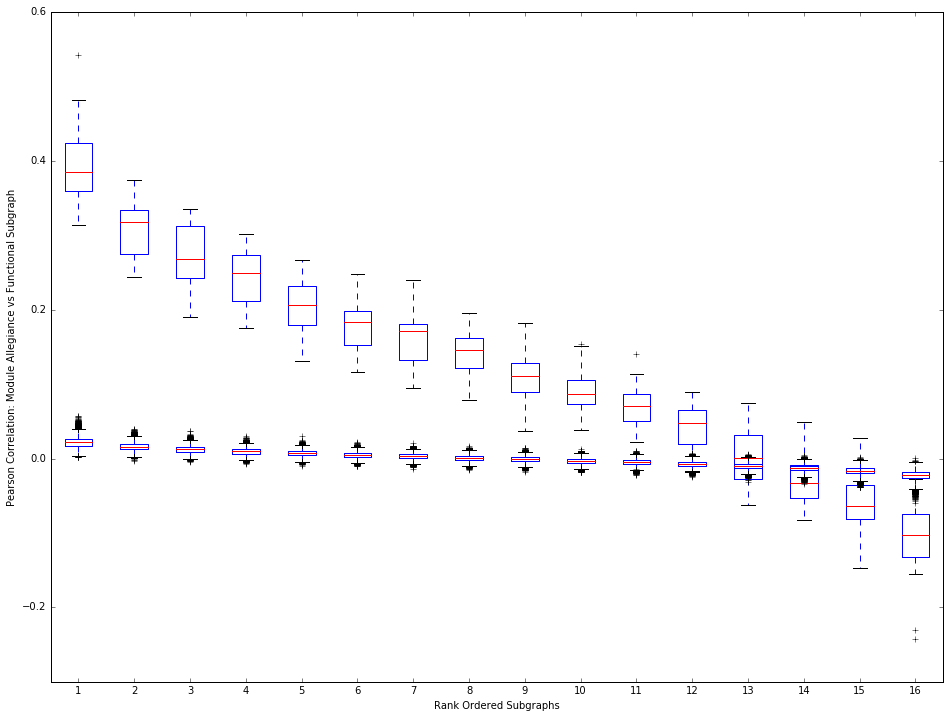

In [146]:
%matplotlib inline

n_subj = len(subj_dict.keys())

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    
    if subj_i == 0:
        rho_subg_pop = np.zeros((n_subj, n_fac))
        rho_subg_pop_null = np.array([]).reshape(0, n_fac)
        rank_subg_pop = np.zeros((n_subj, n_fac))
    
    # Module Allegiance Matrix
    subj_module_alleg = np.zeros((n_node, n_node))
    for iw in xrange(n_win):
        module_id = np.unique(module_assign[iw, :])

        for m_id in module_id:
            m_nodes = np.flatnonzero(module_assign[iw, :] == m_id)
            n1, n2 = np.meshgrid(m_nodes, m_nodes)
            subj_module_alleg[n1, n2] += 1
    subj_module_alleg_conn = subj_module_alleg[triu_ix, triu_iy]

    # Correlation between Subgraph and Module Allegiance
    rho_subg = []
    pval_subg = []
    for f_id in xrange(n_fac):
        fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()
        rho, pval = stats.pearsonr(subj_module_alleg_conn, fac_subgraph_norm)
        rho_subg.append(rho)
        pval_subg.append(pval)   
    rho_subg_pop[subj_i, :] = np.sort(rho_subg)[::-1]
    rank_subg_pop[subj_i, :] = np.argsort(rho_subg)[::-1]
    
    # Null Correlation between Subgraph and Module Allegiance
    for ns in xrange(1000):
        rho_subg_null = []
        for f_id in xrange(n_fac):
            fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()        
            rho, _ = stats.pearsonr(subj_module_alleg_conn,
                                    np.random.permutation(fac_subgraph_norm))
            rho_subg_null.append(rho)
        rho_subg_pop_null = np.vstack((rho_subg_pop_null,
                                       np.sort(rho_subg_null)[::-1]))

        
    if subj_i == 0:
        # Plot Module Allegiance
        plt.figure(figsize=(16, 12))
        ax = plt.subplot(4, 4, 3)
        ax.matshow(subj_module_alleg);
        ax.set_axis_off()
        ax.set_title('{} \n Module Allegiance'.format(subj));

        # Plot Subgraph in Matching Order
        plt.figure(figsize=(16, 12))
        for ii, f_id in enumerate(map(int, rank_subg_pop[subj_i, :])):
            ax = plt.subplot(4, 4, ii+1)

            ax.matshow(Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(fac_subgraph[f_id, :]));
            ax.set_axis_off()
            ax.set_title('Rho: %0.4f, Pval: %0.2e' % (rho_subg[f_id], pval_subg[f_id]));
        plt.show()

for f_id in xrange(n_fac):
    print(stats.ranksums(rho_subg_pop[:, f_id],
                         rho_subg_pop_null[:, f_id]))
    
# Plot Distribution of Correlation
plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ax.boxplot(rho_subg_pop);
ax.boxplot(rho_subg_pop_null);
ax.set_ylabel('Pearson Correlation: Module Allegiance vs Functional Subgraph');
ax.set_xlabel('Rank Ordered Subgraphs');
rho_modalleg = rho_subg_pop[...]

### Connection Strengths are Heavy-Tailed in Module-Sensitive Subgraphs 

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


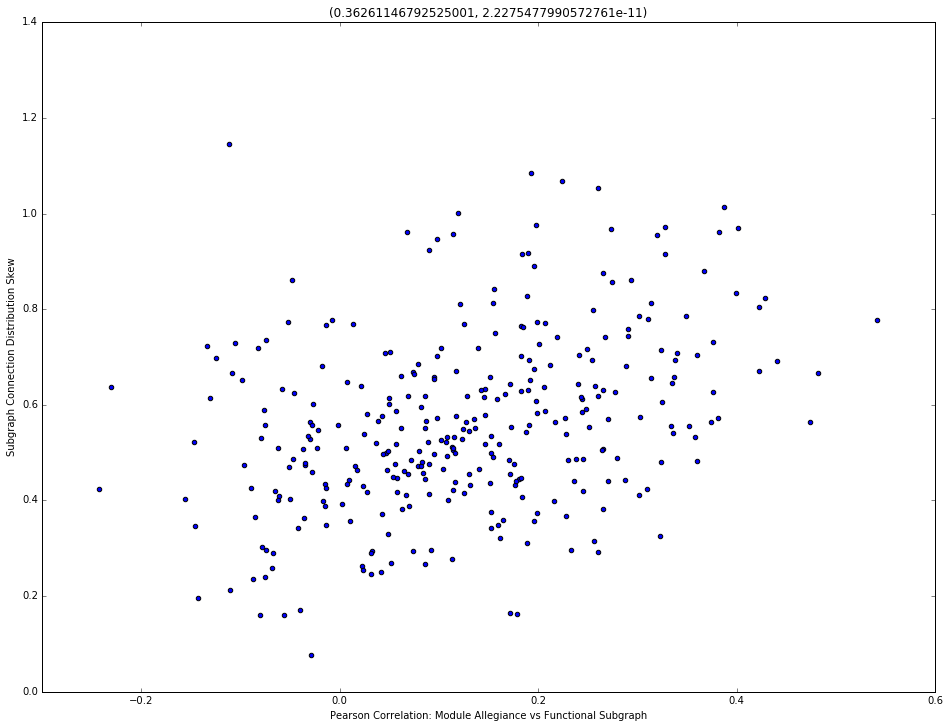

In [147]:
%matplotlib inline

n_subj = len(subj_dict.keys())

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    
    if subj_i == 0:
        subg_skew_pop = np.zeros((n_subj, n_fac))
    
    # Subgraph Skew
    subg_ord = map(int, rank_subg_pop[subj_i, :])    
    for ii, f_id in enumerate(subg_ord):
        fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()
        subg_skew = stats.skew(fac_subgraph_norm)
        subg_skew_pop[subj_i, ii] = subg_skew

# Plot Distribution of Correlation
plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ax.scatter(rho_subg_pop, subg_skew_pop)
ax.set_xlabel('Pearson Correlation: Module Allegiance vs Functional Subgraph');
ax.set_ylabel('Subgraph Connection Distribution Skew');
ax.set_title(stats.pearsonr(rho_subg_pop.reshape(-1), subg_skew_pop.reshape(-1)));

### Module-Sensitive Subgraphs Exhibit High Network Synchronizability

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


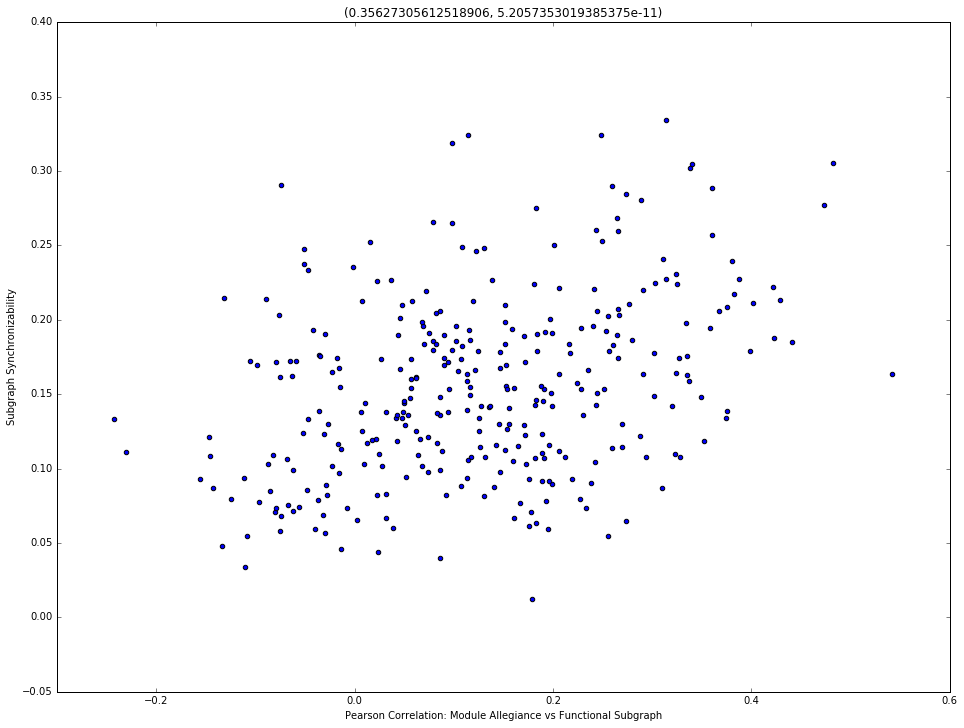

In [148]:
def global_sync(adj_matr):
    """Compute synchronizability"""

    # Get the degree vector of the adj
    deg_vec = np.sum(adj_matr, axis=0)
    deg_matr = np.diag(deg_vec)

    # Laplacian
    lapl = deg_matr - adj_matr

    # Compute eigenvalues and eigenvectors, ensure they are real
    eigval, eigvec = np.linalg.eig(lapl)
    eigval = np.real(eigval)

    # Sort smallest to largest eigenvalue
    eigval = np.sort(eigval)
    sync = np.abs(eigval[1] / eigval[-1])

    return sync

%matplotlib inline

n_subj = len(subj_dict.keys())

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    
    if subj_i == 0:
        subg_sync_pop = np.zeros((n_subj, n_fac))
    
    # Subgraph Skew
    subg_ord = map(int, rank_subg_pop[subj_i, :])    
    for ii, f_id in enumerate(subg_ord):
        fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()
        subg_sync = global_sync(Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(fac_subgraph_norm))
        subg_sync_pop[subj_i, ii] = subg_sync

        # Try mean of subgraph... average connection strength may play a role here...


# Plot Distribution of Correlation
plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ax.scatter(rho_subg_pop, subg_sync_pop)
ax.set_xlabel('Pearson Correlation: Module Allegiance vs Functional Subgraph');
ax.set_ylabel('Subgraph Synchronizability');
ax.set_title(stats.pearsonr(rho_subg_pop.reshape(-1), subg_sync_pop.reshape(-1)))

### Module-Sensitive Subgraphs Have High Basal Temporal Expression

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


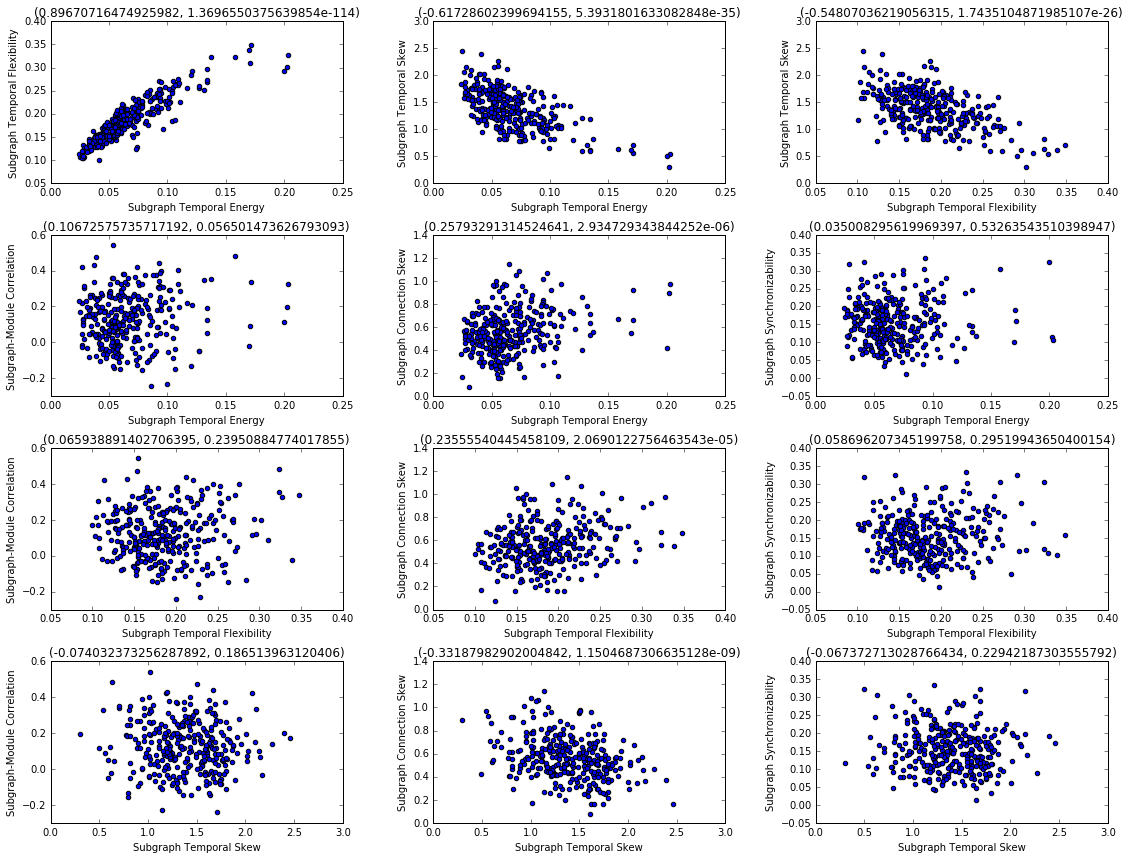

In [152]:
%matplotlib inline

n_subj = len(subj_dict.keys())

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]
    

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    
    if subj_i == 0:
        subg_flex_pop = np.zeros((n_subj, n_fac))
        subg_energy_pop = np.zeros((n_subj, n_fac))        
        subg_tskew_pop = np.zeros((n_subj, n_fac))        
    
    # Subgraph Temporal Features
    subg_ord = map(int, rank_subg_pop[subj_i, :])    
    for ii, f_id in enumerate(subg_ord):
        fac_coef_norm = fac_coef[f_id, :] / fac_coef[f_id, :].max()
        r_win = int(n_win / 4.0)
        
        run = []
        for rr in xrange(4):
            run.append(np.mean(np.abs(np.diff(fac_coef_norm[rr*r_win:(rr+1)*r_win]))))
        subg_flex_pop[subj_i, ii] = np.mean(run)
        
        run = []
        for rr in xrange(4):
            run.append(np.mean(fac_coef_norm[rr*r_win:(rr+1)*r_win]**2))
        subg_energy_pop[subj_i, ii] = np.mean(run)

        run = []
        for rr in xrange(4):
            run.append(stats.skew(fac_coef_norm[rr*r_win:(rr+1)*r_win]))
        subg_tskew_pop[subj_i, ii] = np.mean(run)

plt.figure(figsize=(16, 12))        
# Plot Distribution of Temporal Energy vs Flexibility
ax = plt.subplot(4,3,1)
ax.scatter(subg_energy_pop, subg_flex_pop)
ax.set_xlabel('Subgraph Temporal Energy');
ax.set_ylabel('Subgraph Temporal Flexibility');
ax.set_title(stats.pearsonr(subg_energy_pop.reshape(-1),
                            subg_flex_pop.reshape(-1)));

# Plot Distribution of Temporal Energy vs Skew
ax = plt.subplot(4,3,2)
ax.scatter(subg_energy_pop, subg_tskew_pop)
ax.set_xlabel('Subgraph Temporal Energy');
ax.set_ylabel('Subgraph Temporal Skew');
ax.set_title(stats.pearsonr(subg_energy_pop.reshape(-1),
                            subg_tskew_pop.reshape(-1)));

# Plot Distribution of Temporal Flexibility vs Skew
ax = plt.subplot(4,3,3)
ax.scatter(subg_flex_pop, subg_tskew_pop)
ax.set_xlabel('Subgraph Temporal Flexibility');
ax.set_ylabel('Subgraph Temporal Skew');
ax.set_title(stats.pearsonr(subg_flex_pop.reshape(-1),
                            subg_tskew_pop.reshape(-1)));

# Plot Distribution of Temporal Energy vs Subgraph-Module Correlation
ax = plt.subplot(4,3,4)
ax.scatter(subg_energy_pop, rho_subg_pop)
ax.set_xlabel('Subgraph Temporal Energy');
ax.set_ylabel('Subgraph-Module Correlation');
ax.set_title(stats.pearsonr(subg_energy_pop.reshape(-1),
                            rho_subg_pop.reshape(-1)));

# Plot Distribution of Temporal Energy vs Subgraph Skew
ax = plt.subplot(4,3,5)
ax.scatter(subg_energy_pop, subg_skew_pop)
ax.set_xlabel('Subgraph Temporal Energy');
ax.set_ylabel('Subgraph Connection Skew');
ax.set_title(stats.pearsonr(subg_energy_pop.reshape(-1),
                            subg_skew_pop.reshape(-1)));

# Plot Distribution of Temporal Energy vs Subgraph Synchronzability
ax = plt.subplot(4,3,6)
ax.scatter(subg_energy_pop, subg_sync_pop)
ax.set_xlabel('Subgraph Temporal Energy');
ax.set_ylabel('Subgraph Synchronizability');
ax.set_title(stats.pearsonr(subg_energy_pop.reshape(-1),
                            subg_sync_pop.reshape(-1)));

# Plot Distribution of Temporal Flexibility vs Subgraph-Module Correlation
ax = plt.subplot(4,3,7)
ax.scatter(subg_flex_pop, rho_subg_pop)
ax.set_xlabel('Subgraph Temporal Flexibility');
ax.set_ylabel('Subgraph-Module Correlation');
ax.set_title(stats.pearsonr(subg_flex_pop.reshape(-1),
                            rho_subg_pop.reshape(-1)));

# Plot Distribution of Temporal Flexibility vs Subgraph Skew
ax = plt.subplot(4,3,8)
ax.scatter(subg_flex_pop, subg_skew_pop)
ax.set_xlabel('Subgraph Temporal Flexibility');
ax.set_ylabel('Subgraph Connection Skew');
ax.set_title(stats.pearsonr(subg_flex_pop.reshape(-1),
                            subg_skew_pop.reshape(-1)));

# Plot Distribution of Temporal Flexibility vs Subgraph Synchronzability
ax = plt.subplot(4,3,9)
ax.scatter(subg_flex_pop, subg_sync_pop)
ax.set_xlabel('Subgraph Temporal Flexibility');
ax.set_ylabel('Subgraph Synchronizability');
ax.set_title(stats.pearsonr(subg_flex_pop.reshape(-1),
                            subg_sync_pop.reshape(-1)));

# Plot Distribution of Temporal Skew vs Subgraph-Module Correlation
ax = plt.subplot(4,3,10)
ax.scatter(subg_tskew_pop, rho_subg_pop)
ax.set_xlabel('Subgraph Temporal Skew');
ax.set_ylabel('Subgraph-Module Correlation');
ax.set_title(stats.pearsonr(subg_tskew_pop.reshape(-1),
                            rho_subg_pop.reshape(-1)));

# Plot Distribution of Temporal Skew vs Subgraph Skew
ax = plt.subplot(4,3,11)
ax.scatter(subg_tskew_pop, subg_skew_pop)
ax.set_xlabel('Subgraph Temporal Skew');
ax.set_ylabel('Subgraph Connection Skew');
ax.set_title(stats.pearsonr(subg_tskew_pop.reshape(-1),
                            subg_skew_pop.reshape(-1)));

# Plot Distribution of Temporal Skew vs Subgraph Synchronzability
ax = plt.subplot(4,3,12)
ax.scatter(subg_tskew_pop, subg_sync_pop)
ax.set_xlabel('Subgraph Temporal Skew');
ax.set_ylabel('Subgraph Synchronizability');
ax.set_title(stats.pearsonr(subg_tskew_pop.reshape(-1),
                            subg_sync_pop.reshape(-1)));

plt.tight_layout()

# mediation model (see Medaglia email)


## Subgraph Topography

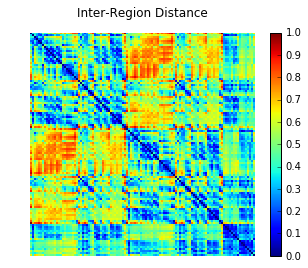

In [123]:
# Generate Node Distance Matrix
df = pd.read_csv('{}/Atlas/HOA112_Labels.csv'.format(path_CoreData))
n_node = len(df)

dist_matr = np.zeros((n_node, n_node))
ix, iy = np.mgrid[:n_node, :n_node]

dX = np.array(df.X)
dY = np.array(df.Y)
dZ = np.array(df.Z)

dist_matr[ix, iy] = np.sqrt((dX[ix]-dX[iy])**2 + 
                            (dY[ix]-dY[iy])**2 +
                            (dZ[ix]-dZ[iy])**2)
dist_matr /= dist_matr.max()

%matplotlib inline
plt.figure()
ax = plt.subplot(111)
mat = ax.matshow(dist_matr)
plt.colorbar(mat, ax=ax)
ax.set_title('Inter-Region Distance')
ax.set_axis_off()

### Are Subgraphs Sensitive to Spatially Distributed vs Localized Connections?

 -- Processing: h010615p


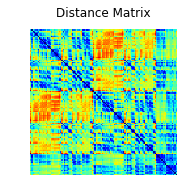

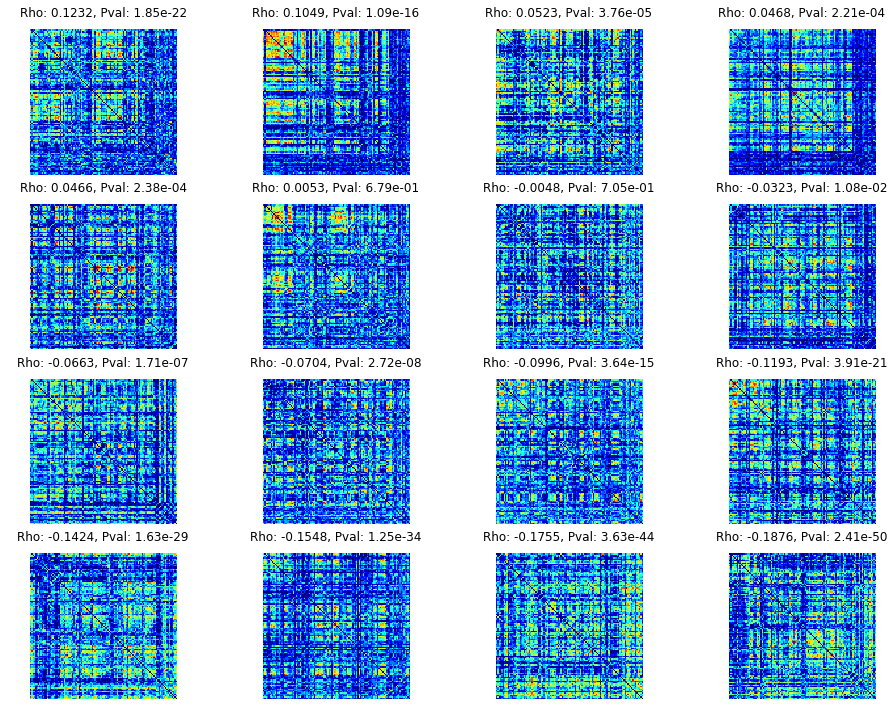

 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o
RanksumsResult(statistic=7.7419032595748289, pvalue=9.7939500150038036e-15)
RanksumsResult(statistic=7.7419032595748289, pvalue=9.7939500150038036e-15)
RanksumsResult(statistic=7.4340851859741335, pvalue=1.0529410114640039e-13)
RanksumsResult(statistic=6.8846810211584062, pvalue=5.7917163136491907e-12)
RanksumsResult(statistic=1.6761220556979506, pvalue=0.093714287414896041)
RanksumsResult(statistic=-2.3019000961693838, pvalue=0.021340806797028228)
RanksumsResult(statistic=-4.1590278500761944, pvalue=3.1960493366087736e

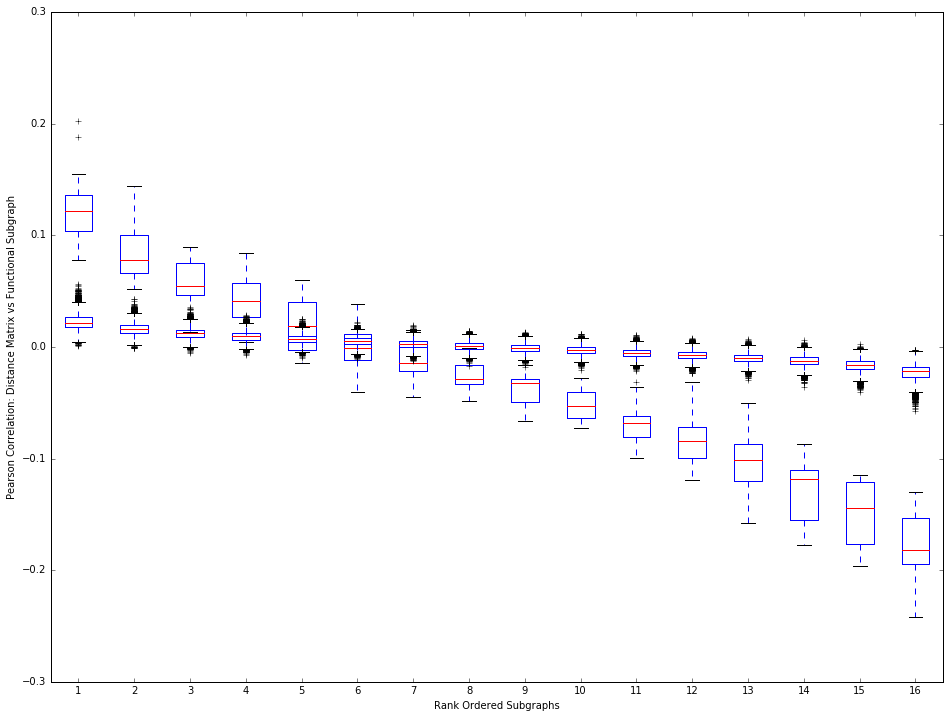

In [138]:
%matplotlib inline

n_subj = len(subj_dict.keys())

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    
    if subj_i == 0:
        rho_subg_pop = np.zeros((n_subj, n_fac))
        rho_subg_pop_null = np.array([]).reshape(0, n_fac)
        rank_subg_pop = np.zeros((n_subj, n_fac))
    
    conn_dist = dist_matr[triu_ix, triu_iy]

    # Correlation between Subgraph and Distance Matrix
    rho_subg = []
    pval_subg = []
    for f_id in xrange(n_fac):
        fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()
        rho, pval = stats.pearsonr(conn_dist, fac_subgraph_norm)
        rho_subg.append(rho)
        pval_subg.append(pval)   
    rho_subg_pop[subj_i, :] = np.sort(rho_subg)[::-1]
    rank_subg_pop[subj_i, :] = np.argsort(rho_subg)[::-1]
    
    # Null Correlation between Subgraph and Distance Matrix
    for ns in xrange(1000):
        rho_subg_null = []
        for f_id in xrange(n_fac):
            fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()        
            rho, _ = stats.pearsonr(conn_dist,
                                    np.random.permutation(fac_subgraph_norm))
            rho_subg_null.append(rho)
        rho_subg_pop_null = np.vstack((rho_subg_pop_null,
                                       np.sort(rho_subg_null)[::-1]))
        
    if subj_i == 0:
        # Plot Distance Matrix
        plt.figure(figsize=(16, 12))
        ax = plt.subplot(4, 4, 3)
        ax.matshow(dist_matr);
        ax.set_axis_off()
        ax.set_title('Distance Matrix'.format(subj));

        # Plot Subgraph in Matching Order
        plt.figure(figsize=(16, 12))
        for ii, f_id in enumerate(map(int, rank_subg_pop[subj_i, :])):
            ax = plt.subplot(4, 4, ii+1)

            ax.matshow(Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(fac_subgraph[f_id, :]));
            ax.set_axis_off()
            ax.set_title('Rho: %0.4f, Pval: %0.2e' % (rho_subg[f_id], pval_subg[f_id]));
        plt.show()
        

for f_id in xrange(n_fac):
    print(stats.ranksums(rho_subg_pop[:, f_id],
                         rho_subg_pop_null[:, f_id]))
    
# Plot Distribution of Correlation
plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ax.boxplot(rho_subg_pop);
ax.boxplot(rho_subg_pop_null);
ax.set_ylabel('Pearson Correlation: Distance Matrix vs Functional Subgraph');
ax.set_xlabel('Rank Ordered Subgraphs');
rho_dist = rho_subg_pop[...]

### Module-Sensitive Subgraphs Are Invariant to Connection Distance/Strength Relationships

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


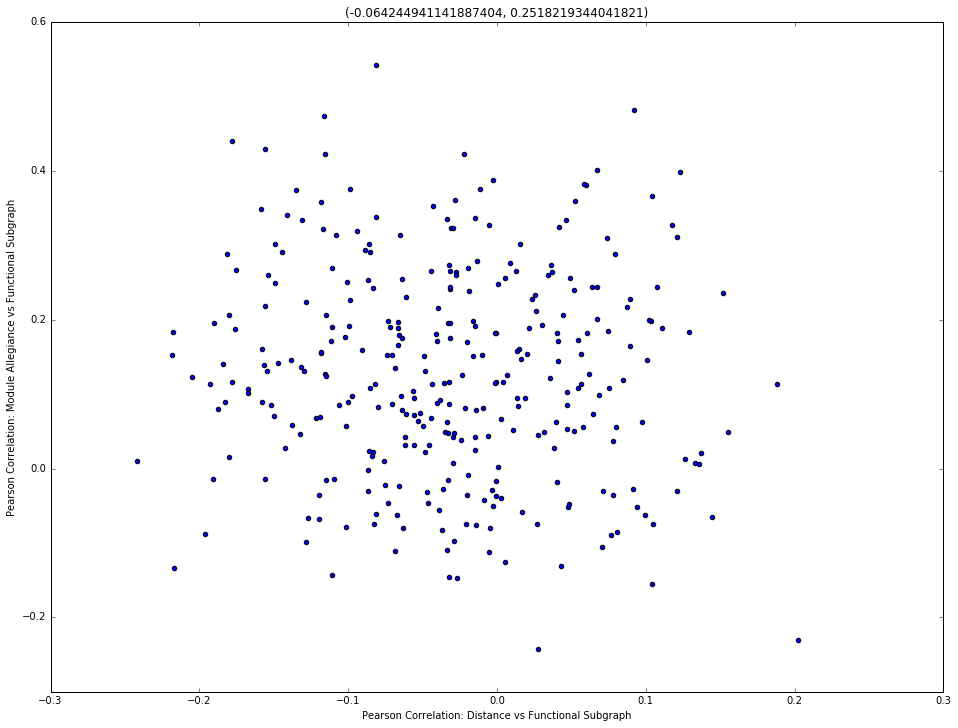

In [144]:
%matplotlib inline

n_subj = len(subj_dict.keys())

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    
    if subj_i == 0:
        subg_modalleg_pop = np.zeros((n_subj, n_fac))
    
    # Module Allegiance Matrix
    subj_module_alleg = np.zeros((n_node, n_node))
    for iw in xrange(n_win):
        module_id = np.unique(module_assign[iw, :])

        for m_id in module_id:
            m_nodes = np.flatnonzero(module_assign[iw, :] == m_id)
            n1, n2 = np.meshgrid(m_nodes, m_nodes)
            subj_module_alleg[n1, n2] += 1
    subj_module_alleg_conn = subj_module_alleg[triu_ix, triu_iy]

    # Correlation between Subgraph and Module Allegiance
    subg_ord = map(int, rank_subg_pop[subj_i, :])    
    for ii, f_id in enumerate(subg_ord):    
        fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()
        rho, pval = stats.pearsonr(subj_module_alleg_conn, fac_subgraph_norm)
        subg_modalleg_pop[subj_i, f_id] = rho
    
# Plot Distribution of Correlation
plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ax.scatter(rho_dist, subg_modalleg_pop)
ax.set_xlabel('Pearson Correlation: Distance vs Functional Subgraph');
ax.set_ylabel('Pearson Correlation: Module Allegiance vs Functional Subgraph');
ax.set_title(stats.pearsonr(rho_dist.reshape(-1), subg_modalleg_pop.reshape(-1)))

### Network Synchronizability Is Enhanced With Short-Range Strong Connectivity

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


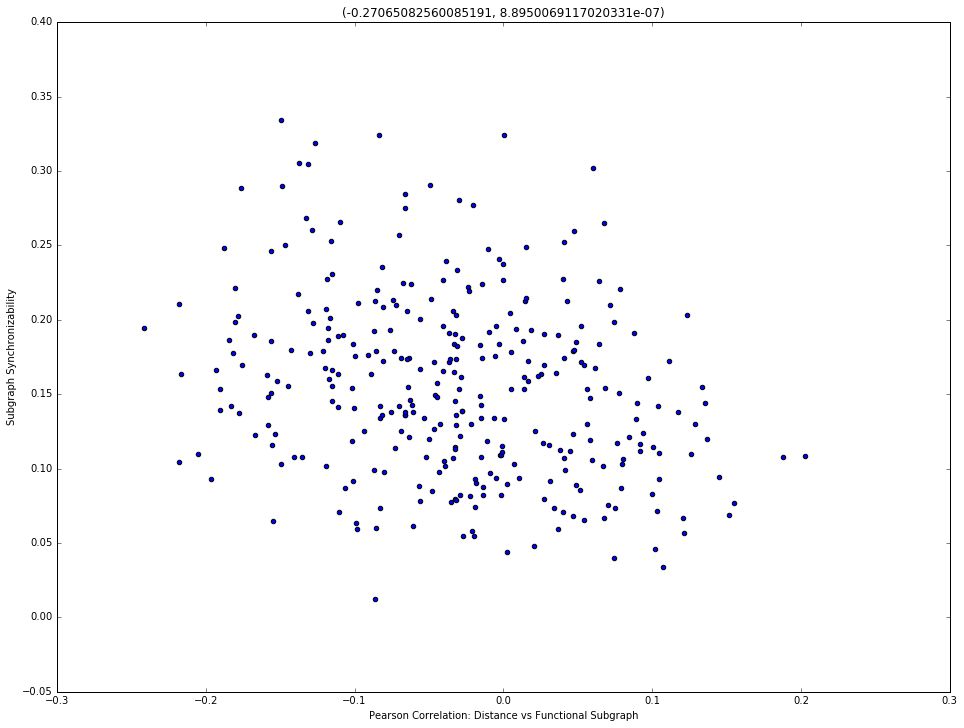

In [140]:
def global_sync(adj_matr):
    """Compute synchronizability"""

    # Get the degree vector of the adj
    deg_vec = np.sum(adj_matr, axis=0)
    deg_matr = np.diag(deg_vec)

    # Laplacian
    lapl = deg_matr - adj_matr

    # Compute eigenvalues and eigenvectors, ensure they are real
    eigval, eigvec = np.linalg.eig(lapl)
    eigval = np.real(eigval)

    # Sort smallest to largest eigenvalue
    eigval = np.sort(eigval)
    sync = np.abs(eigval[1] / eigval[-1])

    return sync

%matplotlib inline

n_subj = len(subj_dict.keys())

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    
    if subj_i == 0:
        subg_sync_pop = np.zeros((n_subj, n_fac))
    
    # Subgraph Skew
    subg_ord = map(int, rank_subg_pop[subj_i, :])    
    for ii, f_id in enumerate(subg_ord):
        fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()
        subg_sync = global_sync(Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(fac_subgraph_norm))
        subg_sync_pop[subj_i, ii] = subg_sync



# Plot Distribution of Correlation
plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ax.scatter(rho_subg_pop, subg_sync_pop)
ax.set_xlabel('Pearson Correlation: Distance vs Functional Subgraph');
ax.set_ylabel('Subgraph Synchronizability');
ax.set_title(stats.pearsonr(rho_subg_pop.reshape(-1), subg_sync_pop.reshape(-1)))

### Is Subgraph Topography Related to Subgraph Dynamics

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


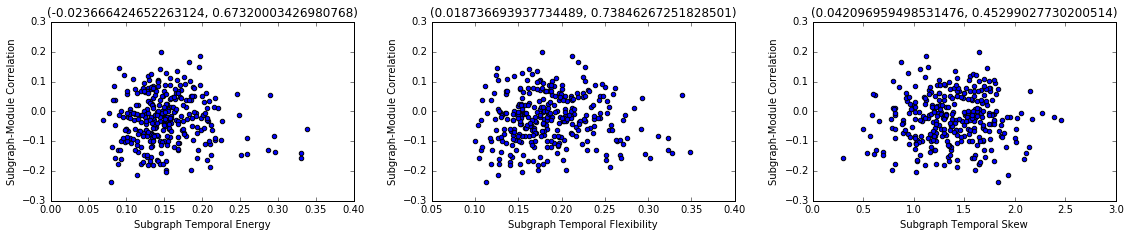

In [132]:
%matplotlib inline

n_subj = len(subj_dict.keys())

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    
    if subj_i == 0:
        subg_flex_pop = np.zeros((n_subj, n_fac))
        subg_energy_pop = np.zeros((n_subj, n_fac))        
        subg_tskew_pop = np.zeros((n_subj, n_fac))        
    
    # Subgraph Flexibility
    subg_ord = map(int, rank_subg_pop[subj_i, :])    
    for ii, f_id in enumerate(subg_ord):
        fac_coef_norm = fac_coef[f_id, :] / fac_coef[f_id, :].max()
        r_win = int(n_win / 4.0)
        
        run = []
        for rr in xrange(4):
            run.append(np.mean(np.abs(np.diff(fac_coef_norm[rr*r_win:(rr+1)*r_win]))))
        subg_flex_pop[subj_i, ii] = np.mean(run)
        
        run = []
        for rr in xrange(4):
            run.append(np.mean(fac_coef_norm[rr*r_win:(rr+1)*r_win]))
        subg_energy_pop[subj_i, ii] = np.mean(run)

        run = []
        for rr in xrange(4):
            run.append(stats.skew(fac_coef_norm[rr*r_win:(rr+1)*r_win]))
        subg_tskew_pop[subj_i, ii] = np.mean(run)

plt.figure(figsize=(16, 12))        
# Plot Distribution of Temporal Energy vs Subgraph-Module Correlation
ax = plt.subplot(4,3,1)
ax.scatter(subg_energy_pop, rho_subg_pop)
ax.set_xlabel('Subgraph Temporal Energy');
ax.set_ylabel('Subgraph-Module Correlation');
ax.set_title(stats.pearsonr(subg_energy_pop.reshape(-1),
                            rho_subg_pop.reshape(-1)));

# Plot Distribution of Temporal Flexibility vs Subgraph-Module Correlation
ax = plt.subplot(4,3,2)
ax.scatter(subg_flex_pop, rho_subg_pop)
ax.set_xlabel('Subgraph Temporal Flexibility');
ax.set_ylabel('Subgraph-Module Correlation');
ax.set_title(stats.pearsonr(subg_flex_pop.reshape(-1),
                            rho_subg_pop.reshape(-1)));


# Plot Distribution of Temporal Skew vs Subgraph-Module Correlation
ax = plt.subplot(4,3,3)
ax.scatter(subg_tskew_pop, rho_subg_pop)
ax.set_xlabel('Subgraph Temporal Skew');
ax.set_ylabel('Subgraph-Module Correlation');
ax.set_title(stats.pearsonr(subg_tskew_pop.reshape(-1),
                            rho_subg_pop.reshape(-1)));


plt.tight_layout()
